Dictionary keys being frequencies, values are np arrays of `Nc x Ns x Nt` (channels x samples x trials). 

First import the data from one session

In [ ]:
data_file_7 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED.txt","r")
data_file_7 = data_file_7.read().split(', ')
for i, v in enumerate(data_file_7):
    if '[' in v:
        data_file_7[i] = v.replace('[','')
    if ']\n' in v:
        data_file_7[i] = v.replace(']\n','')

values_7 = [int(i) for i in data_file_7]

data_file_10 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\10hz\10hz_LED.txt", "r")
data_file_10 = data_file_10.read().split(', ')
for i, v in enumerate(data_file_10):
    if '[' in v:
        data_file_10[i] = v.replace('[','')
    if ']\n' in v:
        data_file_10[i] = v.replace(']\n','')

values_10 = [int(i) for i in data_file_10]

data_file_12 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\12hz\12hz_LED.txt", "r")
data_file_12 = data_file_12.read().split(', ')
for i, v in enumerate(data_file_12):
    if '[' in v:
        data_file_12[i] = v.replace('[','')
    if ']\n' in v:
        data_file_12[i] = v.replace(']\n','')

values_12 = [int(i) for i in data_file_12]

Passband the values

Elliptical 10th order bandpass filter with corner frequencies at (4, 28)Hz,
0.2dB passband ripple and 80dB stopband atten

i.e the same filter that will happen on the board

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

fs = 256
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)

sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

filtered = signal.sosfilt(sos_ellip, values_10[::2])

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

filtered_new = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10[::2])

filtered = filtered[256:]
filtered_board = filtered_new[256:]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
t = np.linspace(0, 29, len(values_10[512::2]), False)

ax1.plot(t, values_10[512::2]-np.mean(values_10[512::2]))
ax1.set_title('Unfiltered')

ax2.plot(t, filtered)
ax2.set_title('Filtered scipy')

ax3.plot(t, filtered_board - np.mean(filtered_board))
ax3.set_title('Filtered board')

Decoding section

GCCA, MsetCCA

In [ ]:
from scipy import signal
import numpy as np

freqs =[7,10,12]
downsample_avg_size = 2

filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10)
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])[256:]

filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_12)
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])[256:]

filtered_7 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_7)
filtered_7 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_7)]*downsample_avg_size)])[256:]

print(filtered_7.shape)
print(filtered_10.shape)
print(filtered_12.shape)

In [ ]:
number_of_train = 4
fs = 256

# synth_7 = (synth_X(7,1,256,4).T).reshape(1,fs,4)

train7_reshape = np.array(filtered_7[:fs*number_of_train]).reshape(number_of_train,fs)
train7 = train7_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train = np.array([train7, train10, train12])

test7 = filtered_7[fs*number_of_train:]
test10 = filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]

print(train7.shape)
print(len(test7)/fs)

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_7 = []
mset_7 =[]

for begin in range(0, int(len(test7)/256)):
    gcca_decode = gcca.classify(test7[256*begin:256*begin+256].reshape(1,256))
    gcca_7.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test7[256*begin:256*begin+256].reshape(1,256))
    mset_7.append(max(mset_decode, key=mset_decode.get))

print(gcca_7.count(7)/len(gcca_7), '\n', mset_7.count(7)/len(mset_7))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/256)):
    gcca_decode = gcca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print(gcca_10.count(10)/len(gcca_10), '\n', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/256)):
    gcca_decode = gcca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print(gcca_12.count(12)/len(gcca_12), '\n', mset_12.count(12)/len(mset_12))

# Using online dataset

In [ ]:
import pandas as pd
from scipy import signal
import numpy as np
import math
from eeg_lib.utils import standardise

df = pd.read_csv(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\online_dataset\data\subject1.csv",sep=';')
s1_8_57 = standardise(df['F1'].to_numpy())
s1_10 = standardise(df['F2'].to_numpy())
s1_12 = standardise(df['F3'].to_numpy())
s1_15 = standardise(df['F4'].to_numpy())


In [ ]:
freqs =[8.57,10,12,15]
fs = 256
number_of_train = 4

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

filtered_857 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_8_57)
filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_10)
filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_12)
filtered_15 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_15)

# filtered_857 = s1_8_57
# filtered_10 = s1_10
# filtered_12 = s1_12
# filtered_15 = s1_15


train857_reshape = np.array(filtered_857[:fs*number_of_train]).reshape(number_of_train,fs)
train857 = train857_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train15_reshape = np.array(filtered_15[:fs*number_of_train]).reshape(number_of_train,fs)
train15 = train15_reshape.T.reshape(1,fs,number_of_train)


# train857 = np.array(filtered_857[len(filtered_857)-256*number_of_train:]).reshape(1,256,number_of_train)
# train10 = np.array(filtered_10[len(filtered_10)-256*number_of_train:]).reshape(1,256,number_of_train)
# train12 = np.array(filtered_12[len(filtered_12)-256*number_of_train:]).reshape(1,256,number_of_train)
# train15 = np.array(filtered_15[len(filtered_15)-256*number_of_train:]).reshape(1,256,number_of_train)

train = np.array([train857, train10, train12, train15])

test857 = filtered_857[256*number_of_train:]
test10= filtered_10[256*number_of_train:]
test12 = filtered_12[256*number_of_train:]
test15 = filtered_15[256*number_of_train:]

# test857 = filtered_857[:len(filtered_857)-256*number_of_train]
# test10= filtered_10[:len(filtered_10)-256*number_of_train]
# test12 = filtered_12[:len(filtered_12)-256*number_of_train]
# test15 = filtered_15[:len(filtered_15)-256*number_of_train]

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_857 = []
mset_857 =[]

for begin in range(0, int(len(test857)/256)):
    gcca_decode = gcca.classify(test857[256*begin:256*begin+256].reshape(1,256))
    gcca_857.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test857[256*begin:256*begin+256].reshape(1,256))
    mset_857.append(max(mset_decode, key=mset_decode.get))

print("GCCA 8.57hz accuracy: ", gcca_857.count(7)/len(gcca_857), '\nMset 8.57hz accuracy: ', mset_857.count(7)/len(mset_857))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/256)):
    gcca_decode = gcca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/256)):
    gcca_decode = gcca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

gcca_15 = []
mset_15 =[]

for begin in range(0, int(len(test15)/256)):
    gcca_decode = gcca.classify(test15[256*begin:256*begin+256].reshape(1,256))
    gcca_15.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test15[256*begin:256*begin+256].reshape(1,256))
    mset_15.append(max(mset_decode, key=mset_decode.get))

print("GCCA 15hz accuracy: ",gcca_15.count(15)/len(gcca_15), '\nMset 15hz accuracy: ', mset_15.count(15)/len(mset_15))

# 64hz over 4 second approach - own data

In [ ]:
import numpy as np
from scipy import signal

data_file_7 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED2.txt", "r")
data_file_7 = data_file_7.read().split(', ')
for i, v in enumerate(data_file_7):
    if '[' in v:
        data_file_7[i] = v.replace('[','')
    if ']\n' in v:
        data_file_7[i] = v.replace(']\n','')

downsample_avg_size = 1

values_7 = [int(i) for i in data_file_7]
values_7 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_7)]*downsample_avg_size)]

data_file_10 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\10hz\10hz_LED2.txt", "r")
data_file_10 = data_file_10.read().split(', ')
for i, v in enumerate(data_file_10):
    if '[' in v:
        data_file_10[i] = v.replace('[','')
    if ']\n' in v:
        data_file_10[i] = v.replace(']\n','')

values_10 = [int(i) for i in data_file_10]
values_10 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_10)]*downsample_avg_size)]

data_file_12 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\12hz\12hz_LED2.txt", "r")
data_file_12 = data_file_12.read().split(', ')
for i, v in enumerate(data_file_12):
    if '[' in v:
        data_file_12[i] = v.replace('[','')
    if ']\n' in v:
        data_file_12[i] = v.replace(']\n','')

values_12 = [int(i) for i in data_file_12] #because sampled at 512, sos filter uses 256
values_12 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_12)]*downsample_avg_size)]

In [ ]:
print(len(values_12), len(values_10),len(values_7))

In [ ]:
freqs =[7,10,12]
fs = 256

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

downsample_avg_size = 1

# filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10)
filtered_10 = values_10
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])

# filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_12)
filtered_12 = values_12
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])

# filtered_7 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_7)
filtered_7 = values_7
filtered_7 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_7)]*downsample_avg_size)])

print(filtered_7.shape)
print(filtered_10.shape)
print(filtered_12.shape)

In [ ]:
number_of_train = 8

train7_reshape = np.array(filtered_7[:fs*number_of_train]).reshape(number_of_train,fs)
train7 = train7_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train = np.array([train7, train10, train12])
test7 = filtered_7[fs*number_of_train:]
test10= filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]

print(train7.shape,len(test7)/256)

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs=512, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_7 = []
mset_7 =[]

for begin in range(0, int(len(test7)/fs)):
    gcca_decode = gcca.classify(test7[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_7.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test7[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_7.append(max(mset_decode, key=mset_decode.get))

print("GCCA 7hz accuracy: ",gcca_7.count(7)/len(gcca_7), '\nMset 7hz accuracy: ', mset_7.count(7)/len(mset_7))

gcca_10 = []
mset_10 = []

for begin in range(0, int(len(test10)/fs)):
    gcca_decode = gcca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/fs)):
    gcca_decode = gcca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

# 64hz over 4 second approach - online dataset
Not enough data in one trial for it

In [166]:
import pandas as pd
from scipy import signal
import numpy as np
import math
from eeg_lib.utils import standardise

df = pd.read_csv(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\online_dataset\data\subject1.csv",sep=';')
s1_8_57 = standardise(df['F1'].to_numpy())
s1_10 = standardise(df['F2'].to_numpy())
s1_12 = standardise(df['F3'].to_numpy())
s1_15 = standardise(df['F4'].to_numpy())
# s1_8_57 = (df['F1'].to_numpy())
# s1_10 = (df['F2'].to_numpy())
# s1_12 = (df['F3'].to_numpy())
# s1_15 = (df['F4'].to_numpy())

freqs =[8.57,10,12,15]
fs = 64
number_of_train = 2

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

downsample_avg_size = 4
filtered_857 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_8_57)
filtered_857 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_857)]*downsample_avg_size)])

filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_10)
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])

filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_12)
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])

filtered_15 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_15)
filtered_15 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_15)]*downsample_avg_size)])

# filtered_857 = s1_8_57
# filtered_10 = s1_10
# filtered_12 = s1_12
# filtered_15 = s1_15

train857_reshape = np.array(filtered_857[:fs*number_of_train]).reshape(number_of_train,fs)
train857 = train857_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train15_reshape = np.array(filtered_15[:fs*number_of_train]).reshape(number_of_train,fs)
train15 = train15_reshape.T.reshape(1,fs,number_of_train)

# train857 = np.array(filtered_857[len(filtered_857)-256*number_of_train:]).reshape(1,256,number_of_train)
# train10 = np.array(filtered_10[len(filtered_10)-256*number_of_train:]).reshape(1,256,number_of_train)
# train12 = np.array(filtered_12[len(filtered_12)-256*number_of_train:]).reshape(1,256,number_of_train)
# train15 = np.array(filtered_15[len(filtered_15)-256*number_of_train:]).reshape(1,256,number_of_train)

train = np.array([train857, train10, train12, train15])

test857 = filtered_857[fs*number_of_train:]
test10= filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]
test15 = filtered_15[fs*number_of_train:]

# test857 = filtered_857[:len(filtered_857)-256*number_of_train]
# test10 = filtered_10[:len(filtered_10)-256*number_of_train]
# test12 = filtered_12[:len(filtered_12)-256*number_of_train]
# test15 = filtered_15[:len(filtered_15)-256*number_of_train]

(4096,)
(4096,)
(4096,)
(4096,)


In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_857 = []
mset_857 =[]

for begin in range(0, int(len(test857)/fs)):
    gcca_decode = gcca.classify(test857[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_857.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test857[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_857.append(max(mset_decode, key=mset_decode.get))

print("GCCA 8.57hz accuracy: ", gcca_857.count(7)/len(gcca_857), '\nMset 8.57hz accuracy: ', mset_857.count(7)/len(mset_857))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/fs)):
    gcca_decode = gcca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/fs)):
    gcca_decode = gcca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

gcca_15 = []
mset_15 = []

for begin in range(0, int(len(test15)/fs)):
    gcca_decode = gcca.classify(test15[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_15.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test15[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_15.append(max(mset_decode, key=mset_decode.get))

print("GCCA 15hz accuracy: ",gcca_15.count(15)/len(gcca_15), '\nMset 15hz accuracy: ', mset_15.count(15)/len(mset_15))

print(mset_15)

# Testing with synthetic signal

In [ ]:
import random
import numpy as np

def synth_x(f, Ns, noise_power=0.5, fs=256):
    """
    generate a synthetic signal vector
    
    args:
    Ns [int]: number of samples (time samples)
    noise_power [float]: variance of WGN noise distribution
    """
    t = np.arange(0, Ns/fs, 1/fs)
    return np.sin(t*2*np.pi*f)*(1+random.random()*noise_power)

def synth_X(f, Nc, Ns, Nt=1, noise_power=0.5, fs=256, f_std=0.02):
    """
    Generate a matrix of several variations of the same target signal. This is used
    to simulate the measurement of a common signal over multiple EEG channels 
    that have different SNR characteristics.
    
    args:
    f [float]: target frequency of synthetic signal (Hz)
    Nc [int]: number of channels
    Ns [int]: number of samples (time samples)
    Ns [int]: number of iid trials
    noise_power [float]: variance of WGN noise distribution
    fs [float]: sampling frequency (Hz)
    f_std [float]: standard dev. of freq. in generated signal across channels to simulate interference from other frequency components over different channels
    """
    def _synth():
        X = []
        for i in range(Nc): # simulate noisy sinusoids with varying SNR across Nc channels
            f_i = f*(1+random.random()*f_std)
            x = synth_x(f_i, Ns, noise_power=noise_power, fs=fs)

            X.append(x)

        return np.array(X)
    
    if Nt <= 1:
        return _synth()
    else:
        trials = []
        for i in range(Nt):
            trials.append(_synth().flatten())

        return np.array(trials)

In [ ]:
freqs = [7, 10, 12]
fs=256

print(synth_X(7,1,256,4).shape)
synth_7 = (synth_X(7,1,256,4).T).reshape(1,fs,4)
print(synth_7.shape)
synth_10 = (synth_X(10,1,256,4).T).reshape(1,fs,4)
synth_12 = (synth_X(12,1,256,4).T).reshape(1,fs,4)

train = np.array([synth_7, synth_10, synth_12])

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

synth_7_test = synth_x(7,256).reshape(1,fs)
synth_10_test = synth_x(10,256).reshape(1,fs)
synth_12_test = synth_x(12,256).reshape(1,fs)

print("7")
print(gcca.classify(synth_7_test))
print(mset_cca.classify(synth_7_test))

print("10")
print(gcca.classify(synth_7_test))
print(mset_cca.classify(synth_10_test))

print("12")
print(gcca.classify(synth_7_test))
print(mset_cca.classify(synth_12_test))

### Before this we were taking first batch for train and last batch for test
#### and some functionisation
Change to testing on every batch

In [85]:
import numpy as np
from scipy import signal
from sklearn.model_selection import LeavePOut
import random
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

def synth_x(f, Ns, noise_power=0.5, fs=256):
    t = np.arange(0, Ns/fs, 1/fs)
    return np.sin(t*2*np.pi*f)*(1+random.random()*noise_power)

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [   [5.18442631e-04, 5.91022291e-04, 5.18442631e-04, 1.00000000e00, -1.58700686e00, 6.47826110e-01,],
        [1.00000000e00, -6.71721317e-01, 1.00000000e00, 1.00000000e00, -1.56164716e00, 7.42956116e-01,],
        [1.00000000e00, -1.19862825e00, 1.00000000e00, 1.00000000e00, -1.53434369e00, 8.53024717e-01,],
        [1.00000000e00, -1.36462221e00, 1.00000000e00, 1.00000000e00, -1.52074686e00, 9.31086238e-01,],
        [1.00000000e00, -1.41821305e00, 1.00000000e00, 1.00000000e00, -1.52570664e00, 9.80264626e-01,],
    ])

def load_array_data(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(', ')
    for i, v in enumerate(data_file):
        if '[' in v:
            data_file[i] = v.replace('[','')
        if ']\n' in v:
            data_file[i] = v.replace(']\n','')
            
    values = [int(i) for i in data_file]
    return values

def average_every_n(values, size):
    return np.array([sum(group) / size for group in zip(*[iter(values)]*size)])

def sos_filter_256(values):
    return signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values)

def process_data(data, no_samples, no_train):
    data = data[:int(len(data)/no_samples)*no_samples]
    data_reshape = data.reshape(int(len(data)/no_samples),no_samples)
    data = data_reshape.T.reshape(1,no_samples,int(len(data)/no_samples))
    return np.array(data)

def generate_train_test_idxs(data,no_train):
    lpo = LeavePOut(p=no_train)
    no_trials = data.shape[-1]
    return list(lpo.split(range(no_trials)))

def test_gcca_mset(data, data_idxs, freqs, fs, no_samples):
    # Nf x Nc x Ns x Nt
    gcca = GCCA_SSVEP(freqs, fs, Nh=1)
    mset_cca = MsetCCA_SSVEP(freqs)
    gcca_total_acc = []
    mset_total_acc = []
    # len(data[0][0][0])
    for i in range(1000):
        # Nf x Nc x Ns x Nt
        train = data[:,:,:,data_idxs[i][1]]
        test = data[:,:,:,data_idxs[i][0]]
        
        gcca.fit(train)
        mset_cca.fit(train)
        
        for freq, value in enumerate(freqs):
            gcca_res = []
            mset_res = []
            print("############################# Frequency:", value, " #############################")
            for test_idx in range(test.shape[-1]):
                test_now = test[freq, :, :, test_idx]
                
                gcca_decode = gcca.classify(test_now)
                gcca_res.append(max(gcca_decode, key=gcca_decode.get))
                
                mset_decode = mset_cca.classify(test_now)
                mset_res.append(max(mset_decode, key=mset_decode.get))
            print("GCCA accuracy {gcca_acc}\nMsetCCA {mset_acc}".format(gcca_acc=gcca_res.count(value)/len(gcca_res),mset_acc=mset_res.count(value)/len(mset_res)))
            gcca_total_acc.append(gcca_res.count(value)/len(gcca_res))
            mset_total_acc.append(mset_res.count(value)/len(mset_res))
    print("GCCA Total Average Accuracy:", sum(gcca_total_acc)/len(gcca_total_acc))
    print("MsetCCA Total Average Accuracy:", sum(mset_total_acc)/len(mset_total_acc))

In [86]:
downsample_avg_size = 1
freqs = [7,10,12]
fs = 512
number_of_samples = 512
number_of_train = 4

In [157]:
synth_power = 0

data_file_7 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED3.txt") + synth_power*synth_x(7, len(data_file_7), noise_power=0, fs=512)

values_7 = process_data(average_every_n(data_file_7, downsample_avg_size),number_of_samples,number_of_train)

data_file_10 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\10hz\10hz_LED3.txt") + synth_power*synth_x(10, len(data_file_7), noise_power=0, fs=512)
values_10 = process_data(average_every_n(data_file_10, downsample_avg_size),number_of_samples,number_of_train)

data_file_12 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\12hz\12hz_LED3.txt") + synth_power*synth_x(12, len(data_file_7), noise_power=0, fs=512)
values_12 = process_data(average_every_n(data_file_12, downsample_avg_size),number_of_samples,number_of_train)

print(values_12.shape, values_10.shape, values_7.shape)

data_packed = np.array([values_7, values_10, values_12])

print(data_packed.shape)

(1, 512, 30) (1, 512, 30) (1, 512, 30)
(3, 1, 512, 30)


In [ ]:
train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
print(len(train_test_idxs))
test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples)

# Filtering tests

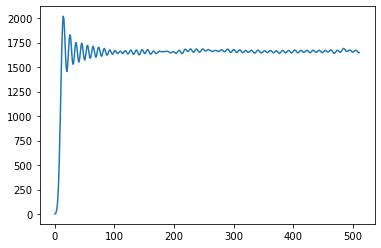

In [161]:
fs = 512
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 50 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)

sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

filtered = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, data_file_7[:512])
# filtered = signal.sosfilt(sos_ellip, data_file_7[:256])

plt.plot(filtered)

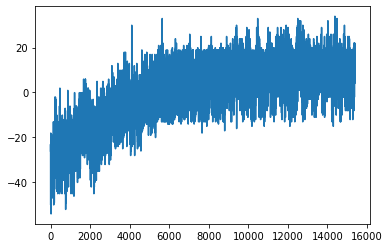

In [154]:
data_file_7_plot = data_file_7 - sum(data_file_7)/len(data_file_7)
plt.plot(data_file_7_plot)

In [141]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

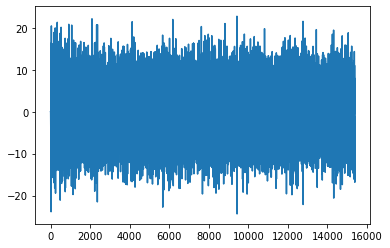

In [155]:
filter_butter = butter_bandpass_filter(data_file_7_plot, 4, 28, 256, order=10)
plt.plot(filter_butter)

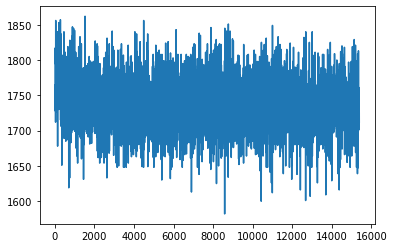

In [75]:
plt.plot(load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED2.txt"))